In [1]:
include("../../src/CoherentStructures.jl") #this is terrible but neccessary during development (?)

Main.CoherentStructures

In [2]:
using DelimitedFiles, Main.CoherentStructures
using Plots

In [3]:
#util functions, partially from /test
using LinearAlgebra
function getInnerProduct(ctx::CoherentStructures.GridContext, u1::Vector{Float64},u2::Vector{Float64},Min=nothing)
        if Min === nothing
            M = assembleMassMatrix(ctx)
        else
            M = Min
        end
        Mu1 = M*u1
        return  u2 ⋅ Mu1
end

function getnorm(u::Vector{T},ctx::CoherentStructures.GridContext,which="L∞", M=nothing) where {T}
    if which == "L∞"
        return maximum(abs.(u))
    elseif which == "L2"
        return sqrt(getInnerProduct(ctx,u,u,M))
    else
        error("Not yet implemented")
    end
end

function getRelativeError(x,y)
    abs(x - y)./abs(y) 
end

function getEigenvectorError(ctx,x,y,M)
    return sqrt(1 - getInnerProduct(ctx,x,y,M)^2/(getnorm(x,ctx,"L2",M)*getnorm(y,ctx,"L2",M))^2)
end

function makeConvergencePlot(errors,grid_resolutions,labels;colors=(1:size(errors)[1]))
    regression_values = [hcat(fill!(similar(grid_resolutions), 1), log.(grid_resolutions)) \ log.(error) 
        for error in errors]
    regression_lines = [[exp(param[1]+log(res)*param[2]) for res in grid_resolutions] for param in regression_values]
    
    labels_with_slope = [labels[i]*" ($(round(regression_values[i][2],digits=1)))" for i in 1:size(errors)[1]]

    Plots.scatter(grid_resolutions,errors,
        markersize=4,markerstrokewidth=0,labels=permutedims(labels_with_slope), color=colors')
    Plots.plot!(grid_resolutions,regression_lines,
        linestyle=:dash, color=colors', labels="")
    Plots.plot!(yaxis=:log,xaxis=:log)
end

makeConvergencePlot (generic function with 1 method)

In [4]:
base_path = "D:/Uni/3 Mathematics in Data Science/05 Masterarbeit/Experimente/"
directory = "double_gyre_convergence_cg/";

In [5]:
quadrature_order       = 5
solver_tolerance       = 1e-8
diff_method            = "autodiff"
grid_resolutions       = [10,20,50,100,200,300,400,500,1000]
reference_file         = "gyre_n=3000_tol=1.0e-12_qo=5_solver=BS5(true)_diff=exact_method=CG.csv"
reference_resolution   = 3000
reference_q0           = 5;

In [6]:
LL, UR = (0.0, 0.0), (1.0, 1.0)
ctx_ref, _ = regularTriangularGrid((reference_resolution, reference_resolution), 
    LL, UR, quadrature_order = reference_q0)
M_ref = assembleMassMatrix(ctx_ref);

In [7]:
file       = readdlm(base_path*directory*reference_file, ',', Float64, '\n')
num_evs    = Int(size(file)[2]/2)

u₀_ref     = file[1:end-1,1:num_evs]
u_dot_ref  = file[1:end-1,num_evs+1:end] 
λ₀_ref     = file[end,1:num_evs] 
λ_dot_ref  = file[end,num_evs+1:end];

len_u₀_ref = size(u₀_ref)[1]
len_u_dot_ref = size(u_dot_ref)[1]
num_grids = length(grid_resolutions);

In [8]:
u₀s = []
u_dots = []
λ₀s = []
λ_dots = []
for res in grid_resolutions
    ctx, _ = regularTriangularGrid((res, res), LL, UR, quadrature_order = quadrature_order)
    file = readdlm(base_path*directory*"gyre"*
           "_n="*string(res)*"_tol="*string(solver_tolerance)*"_qo="*string(quadrature_order)*
           "_solver=BS5(true)_diff="*diff_method*"_method=CG.csv", ',', Float64, '\n')
        
    u₀ = zeros(len_u₀_ref,num_evs)
    for i in 1:num_evs    
        u₀[:,i] = sample_to(file[1:end-1,i],ctx,ctx_ref)
        u₀[:,i] /= getnorm(u₀[:,i],ctx_ref,"L2",M_ref)
    end
    push!(u₀s,u₀)
    
    u_dot = zeros(len_u_dot_ref,num_evs)
    for i in 1:num_evs
        u_dot[:,i] = sample_to(file[1:end-1,i+num_evs],ctx,ctx_ref)
    end
    push!(u_dots,u_dot)
    
    push!(λ₀s,file[end,1:num_evs])
    push!(λ_dots,file[end,num_evs+1:end])
end

In [9]:
plotfile_suffix = "_qo="*string(quadrature_order)*"_tol="*string(solver_tolerance)*"_diff="*diff_method;

## Plots as sanity checks (May take some time, comment out if not neccessary)

In [10]:
plotfile_path = "Plots/Convergence/Sanity/";

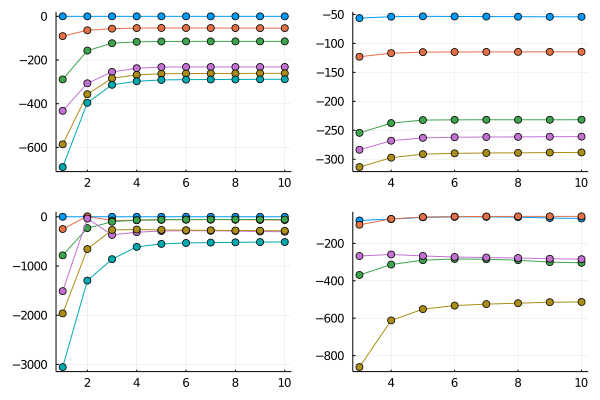

In [11]:
evs_plot = Plots.plot(1:num_grids+1,[push!([λ₀s[i][j] for i in 1:num_grids],λ₀_ref[j]) for j in 1:num_evs],
    marker=:dot,legend=:none,dpi=200)
evs_plot_zoomed = Plots.plot(3:num_grids+1,[push!([λ₀s[i][j] for i in 3:num_grids],λ₀_ref[j]) for j in 2:num_evs],
    marker=:dot,legend=:none,dpi=200)

devs_plot = Plots.plot(1:num_grids+1,[push!([λ_dots[i][j] for i in 1:num_grids],λ_dot_ref[j]) for j in 1:num_evs],
    marker=:dot,legend=:none,dpi=200)
devs_plot_zoomed = Plots.plot(3:num_grids+1,[push!([λ_dots[i][j] for i in 3:num_grids],λ_dot_ref[j]) for j in 2:num_evs],
    marker=:dot,legend=:none,dpi=200)

Plots.savefig(evs_plot,plotfile_path*"eigenvalues"*plotfile_suffix*".png")
Plots.savefig(evs_plot_zoomed,plotfile_path*"eigenvalues_zoomed"*plotfile_suffix*".png")
Plots.savefig(devs_plot,plotfile_path*"deigenvalues"*plotfile_suffix*".png")
Plots.savefig(devs_plot_zoomed,plotfile_path*"deigenvalues_zoomed"*plotfile_suffix*".png")

Plots.plot(evs_plot,evs_plot_zoomed,devs_plot,devs_plot_zoomed,dpi=100)

GKS: Possible loss of precision in routine SET_WINDOW


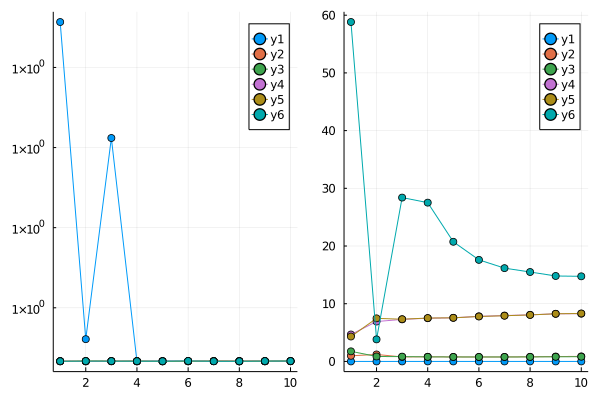

In [12]:
norm_efs = Plots.plot(1:num_grids+1,[push!([getnorm(u₀s[i][:,j],ctx_ref,"L2",M_ref) for i in 1:num_grids],
            getnorm(u₀_ref[:,j],ctx_ref,"L2",M_ref)) for j in 1:num_evs],
    marker=:dot,dpi=200)

norm_defs = Plots.plot(1:num_grids+1,[push!([getnorm(u_dots[i][:,j],ctx_ref,"L2",M_ref) for i in 1:num_grids],
            getnorm(u_dot_ref[:,j],ctx_ref,"L2",M_ref)) for j in 1:num_evs],
    marker=:dot,dpi=200)

Plots.savefig(norm_efs,plotfile_path*"norm_eigenfunctions"*plotfile_suffix*".png")
Plots.savefig(norm_defs,plotfile_path*"norm_deigenfunctions"*plotfile_suffix*".png")


Plots.plot(norm_efs,norm_defs,dpi=100)

In [13]:
color =    :balance
xticks =   0:1:1
yticks =   0:1:1
colorbar = :left
cmins =     [-3.1, -3.1, -3.1, -3.1, -5.0, -5.0]
cmaxs =     -1 .*cmins
cmins_lr =  [-3.1, -3.1, -3.1, -40, -40, -60]
cmaxs_lr =  -1 .*cmins_lr;

In [14]:
for ev in 1:num_evs
    for grid in  1:num_grids
        sign = 1
        if (ev==5&&(grid==3||grid==4||grid==5||grid==6)) || (ev==6&&grid==1)
            sign = -1
        end
        plot = plot_u(ctx_ref, sign.*u₀s[grid][:,ev], reference_resolution, reference_resolution, title="",
            colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks)
        Plots.savefig(plot,plotfile_path*"eigenfunction"*string(ev)*"_res="*string(grid_resolutions[grid])*plotfile_suffix*".png")
    end
    plot = plot_u(ctx_ref, u₀_ref[:,ev], reference_resolution, reference_resolution, title="",
        colorbar=colorbar, color=color, clims=(cmins[ev],cmaxs[ev]), xticks=xticks, yticks=yticks)
    Plots.savefig(plot,plotfile_path*"eigenfunction"*string(ev)*"_res="*string(reference_resolution)*plotfile_suffix*".png")
end

In [25]:
for ev in 1:num_evs
    for grid in  1:num_grids
        sign = 1
        if (ev==5&&(grid==3||grid==4||grid==5||grid==6)) || (ev==6&&grid==1)
            sign = -1
        end
        plot = plot_u(ctx_ref, sign.*u_dots[grid][:,ev], reference_resolution, reference_resolution, title="",
            colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks)
        Plots.savefig(plot,plotfile_path*"deigenfunction"*string(ev)*"_res="*string(grid_resolutions[grid])*plotfile_suffix*".png")
    end
    plot = plot_u(ctx_ref, u_dot_ref[:,ev], reference_resolution, reference_resolution, title="",
        colorbar=colorbar, color=color, clims=(cmins_lr[ev],cmaxs_lr[ev]), xticks=xticks, yticks=yticks)
    Plots.savefig(plot,plotfile_path*"deigenfunction"*string(ev)*"_res="*string(reference_resolution)*plotfile_suffix*".png")
end

## Convergence Plots

In [16]:
plotfile_path = "Plots/Convergence/";

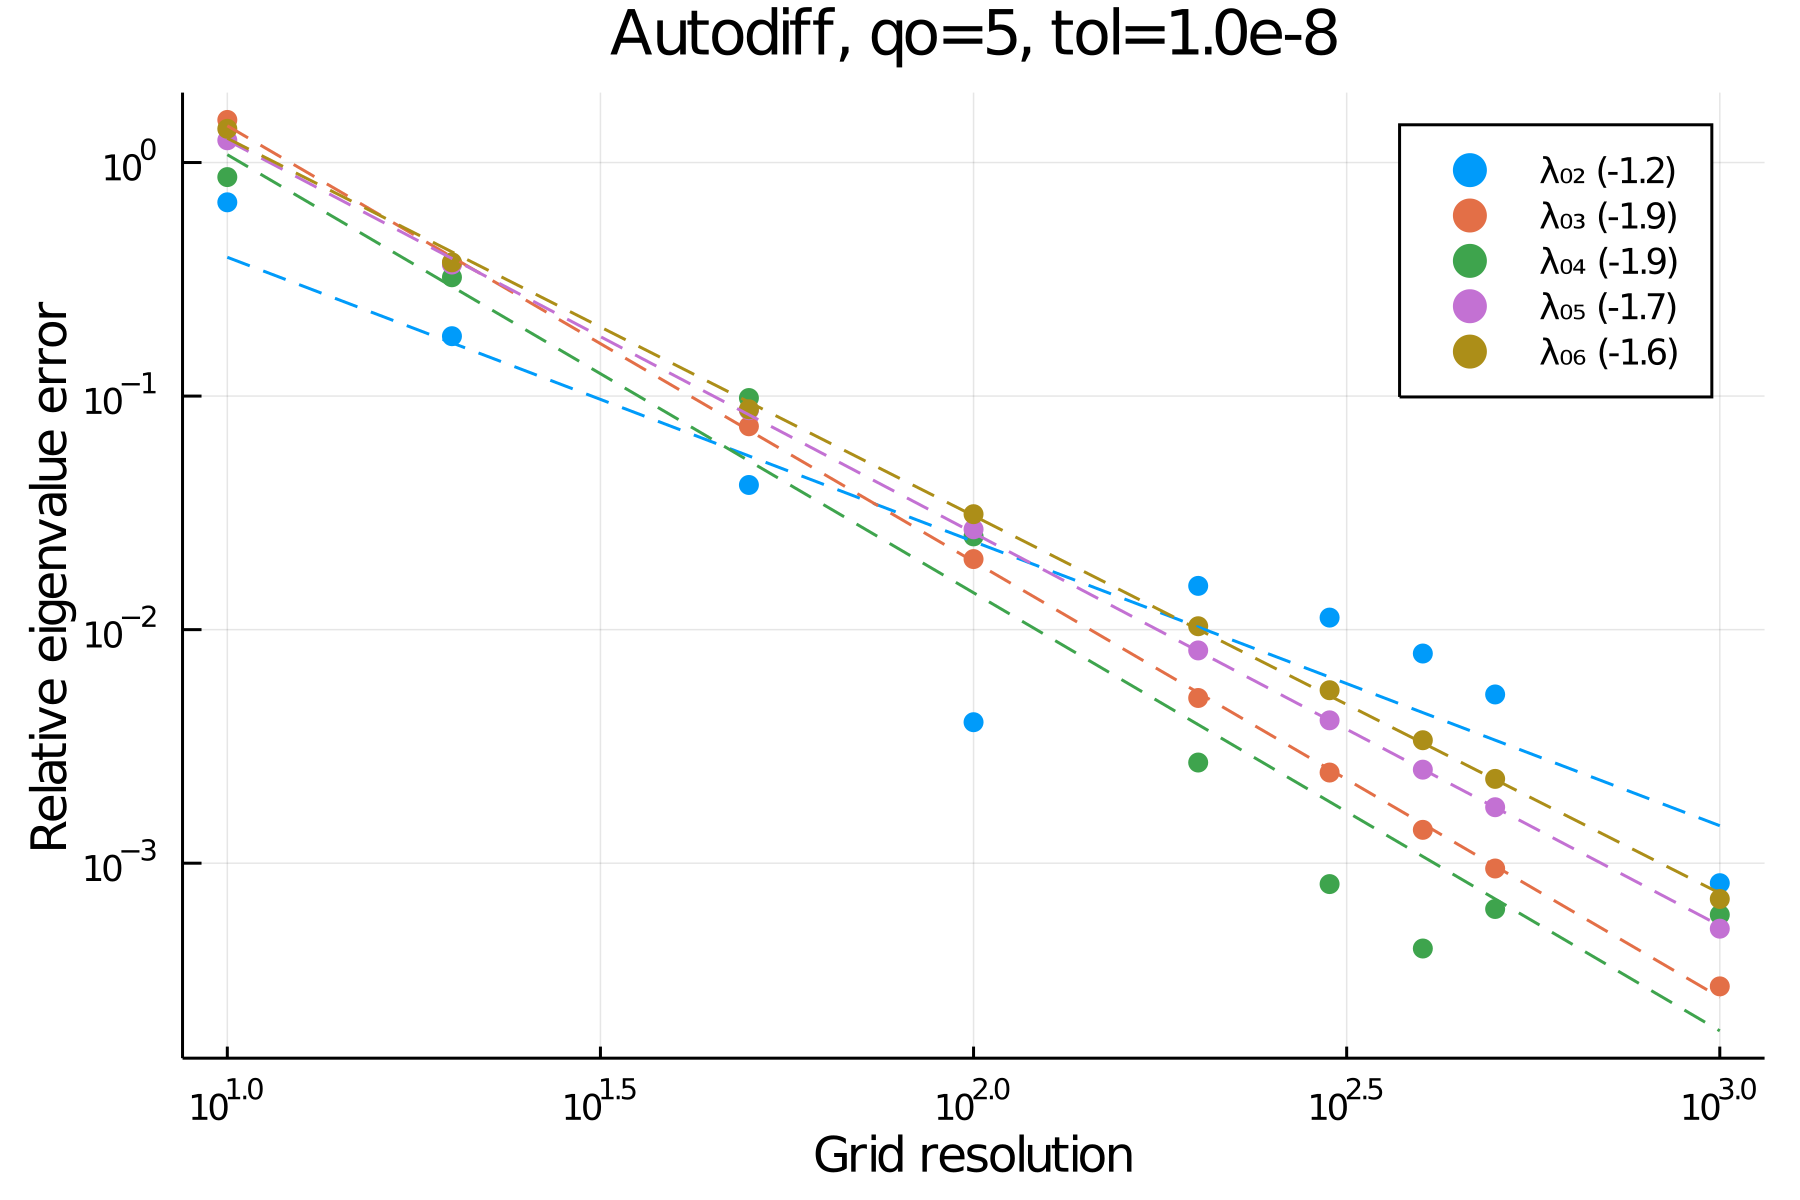

In [17]:
evs_rel_errors = [[getRelativeError(λ₀[ev],λ₀_ref[ev]) for λ₀ in λ₀s] for ev in 2:num_evs]
plot = Plots.plot(makeConvergencePlot(evs_rel_errors,grid_resolutions,["λ₀₂","λ₀₃","λ₀₄","λ₀₅","λ₀₆"]),
    xlabel="Grid resolution",ylabel="Relative eigenvalue error",
    title="Autodiff, qo=$(quadrature_order), tol=$(solver_tolerance)",
    fmt=:png,dpi=300)

Plots.savefig(plot,plotfile_path*"error_eigenvalues"*plotfile_suffix*".png")
Plots.plot(plot)

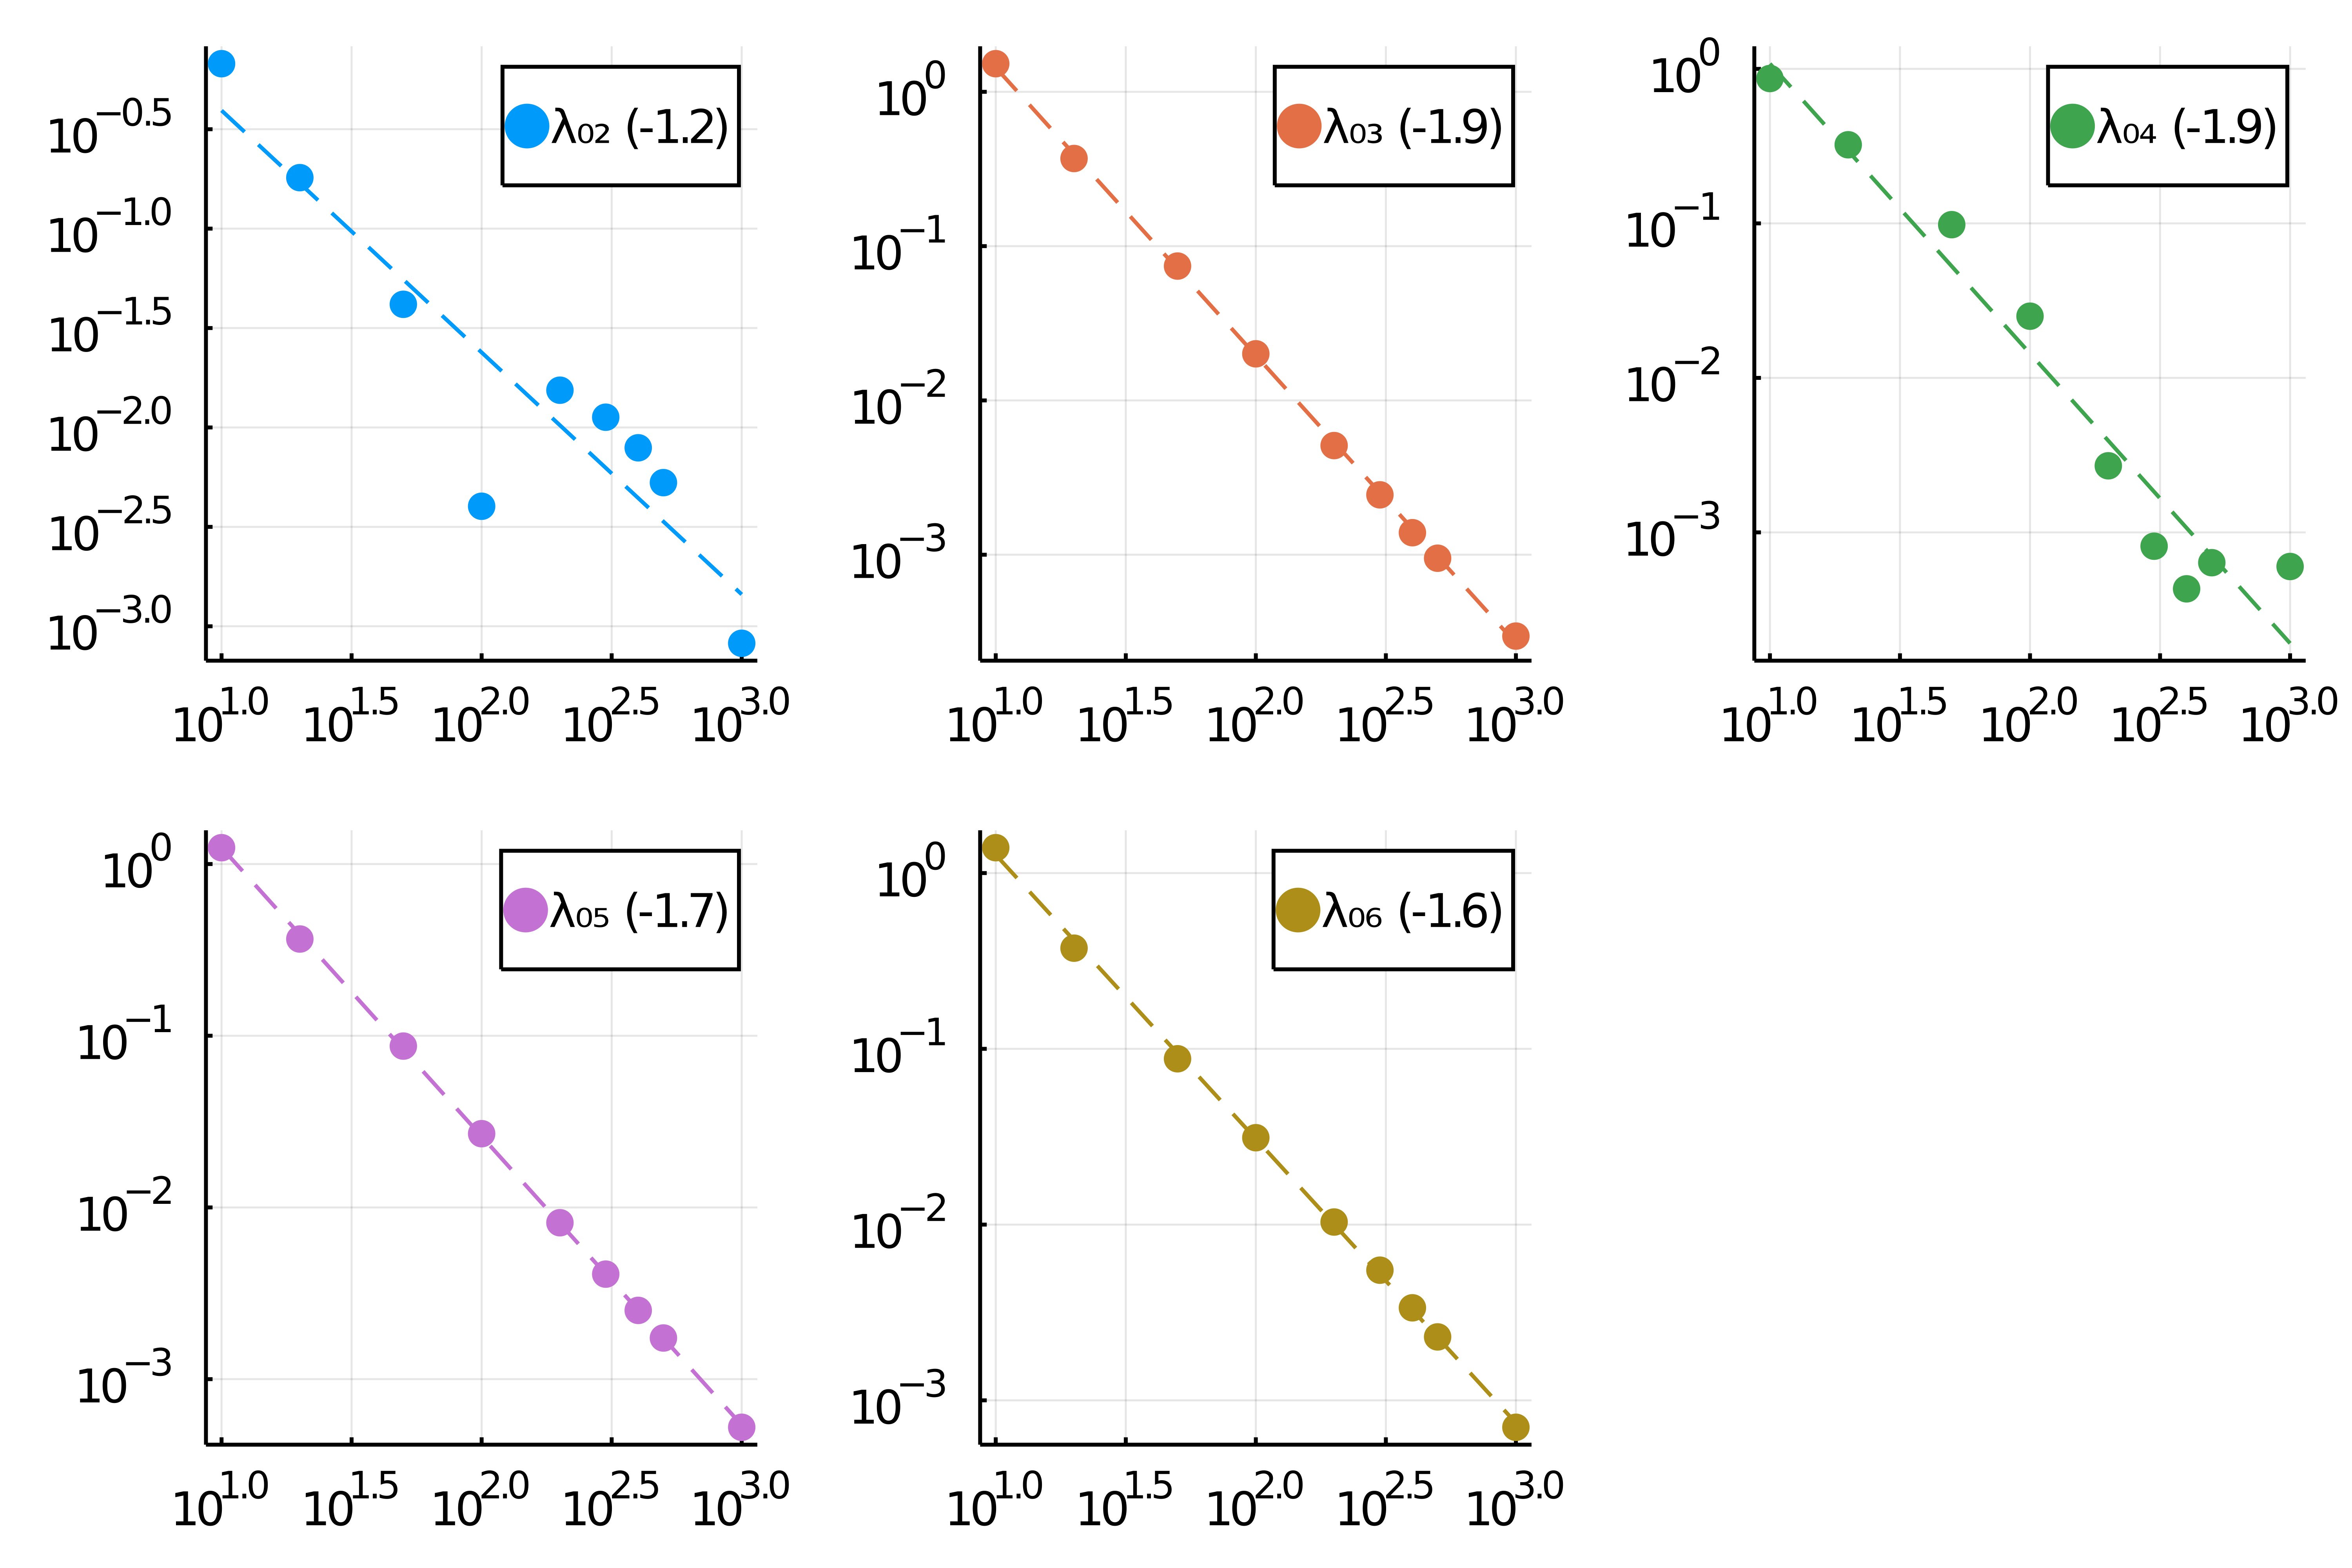

In [18]:
plots = []
labels = ["λ₀₂","λ₀₃","λ₀₄","λ₀₅","λ₀₆"]
for ev in 1:(num_evs-1)
    plot = makeConvergencePlot([evs_rel_errors[ev]],grid_resolutions,[labels[ev]],colors = [ev])
    push!(plots,plot)
    Plots.savefig(plot,plotfile_path*"error_eigenvalue"*string(ev)*plotfile_suffix*".png")
end
Plots.plot(plots...,share=:y,
          fmt=:png,dpi=1000)

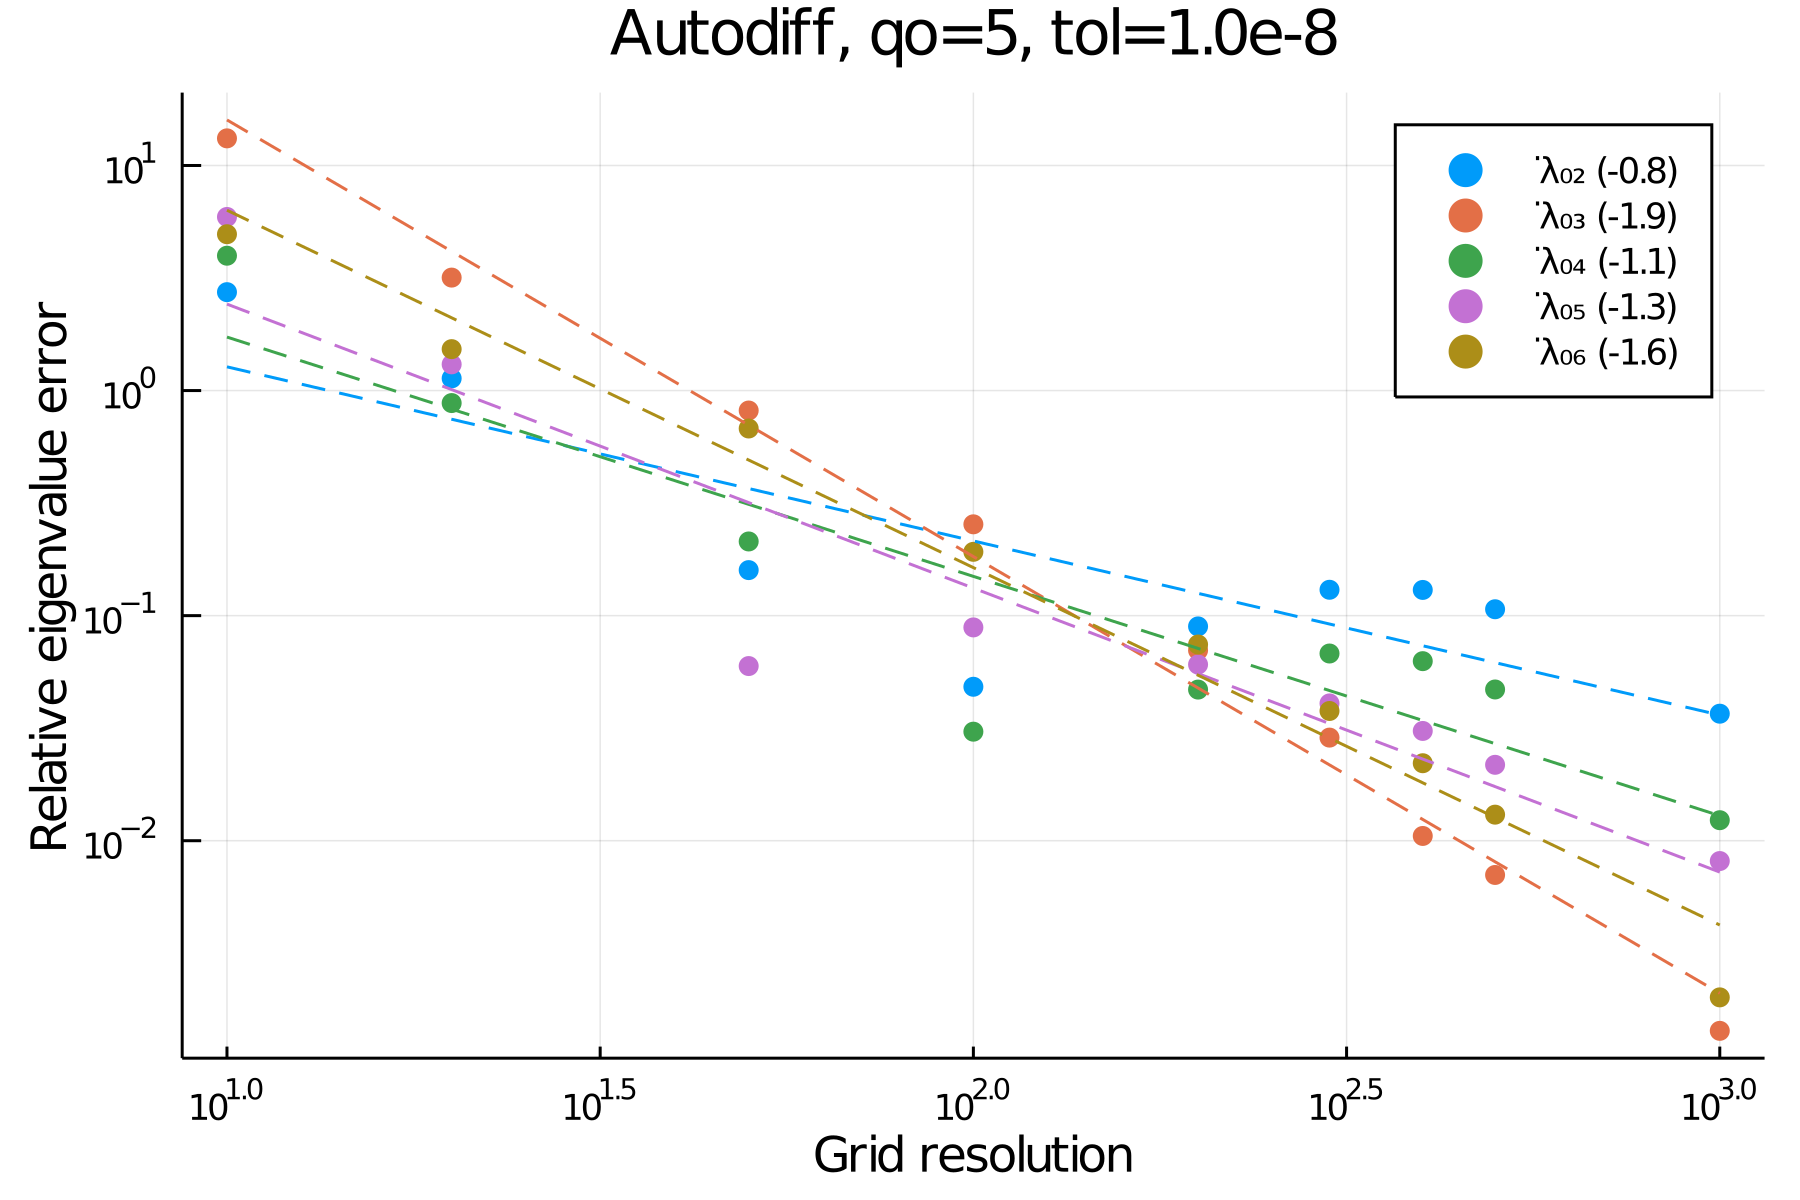

In [19]:
evs_dot_rel_errors = [[getRelativeError(λ_dot[ev],λ_dot_ref[ev]) for λ_dot in λ_dots] for ev in 2:num_evs]
plot = Plots.plot(makeConvergencePlot(evs_dot_rel_errors,grid_resolutions,["̇λ₀₂","̇λ₀₃","̇λ₀₄","̇λ₀₅","̇λ₀₆"]),
    xlabel="Grid resolution",ylabel="Relative eigenvalue error",
    title="Autodiff, qo=$(quadrature_order), tol=$(solver_tolerance)",
    fmt=:png,dpi=300)

Plots.savefig(plot,plotfile_path*"error_eigenvalues"*plotfile_suffix*".png")
Plots.plot(plot)

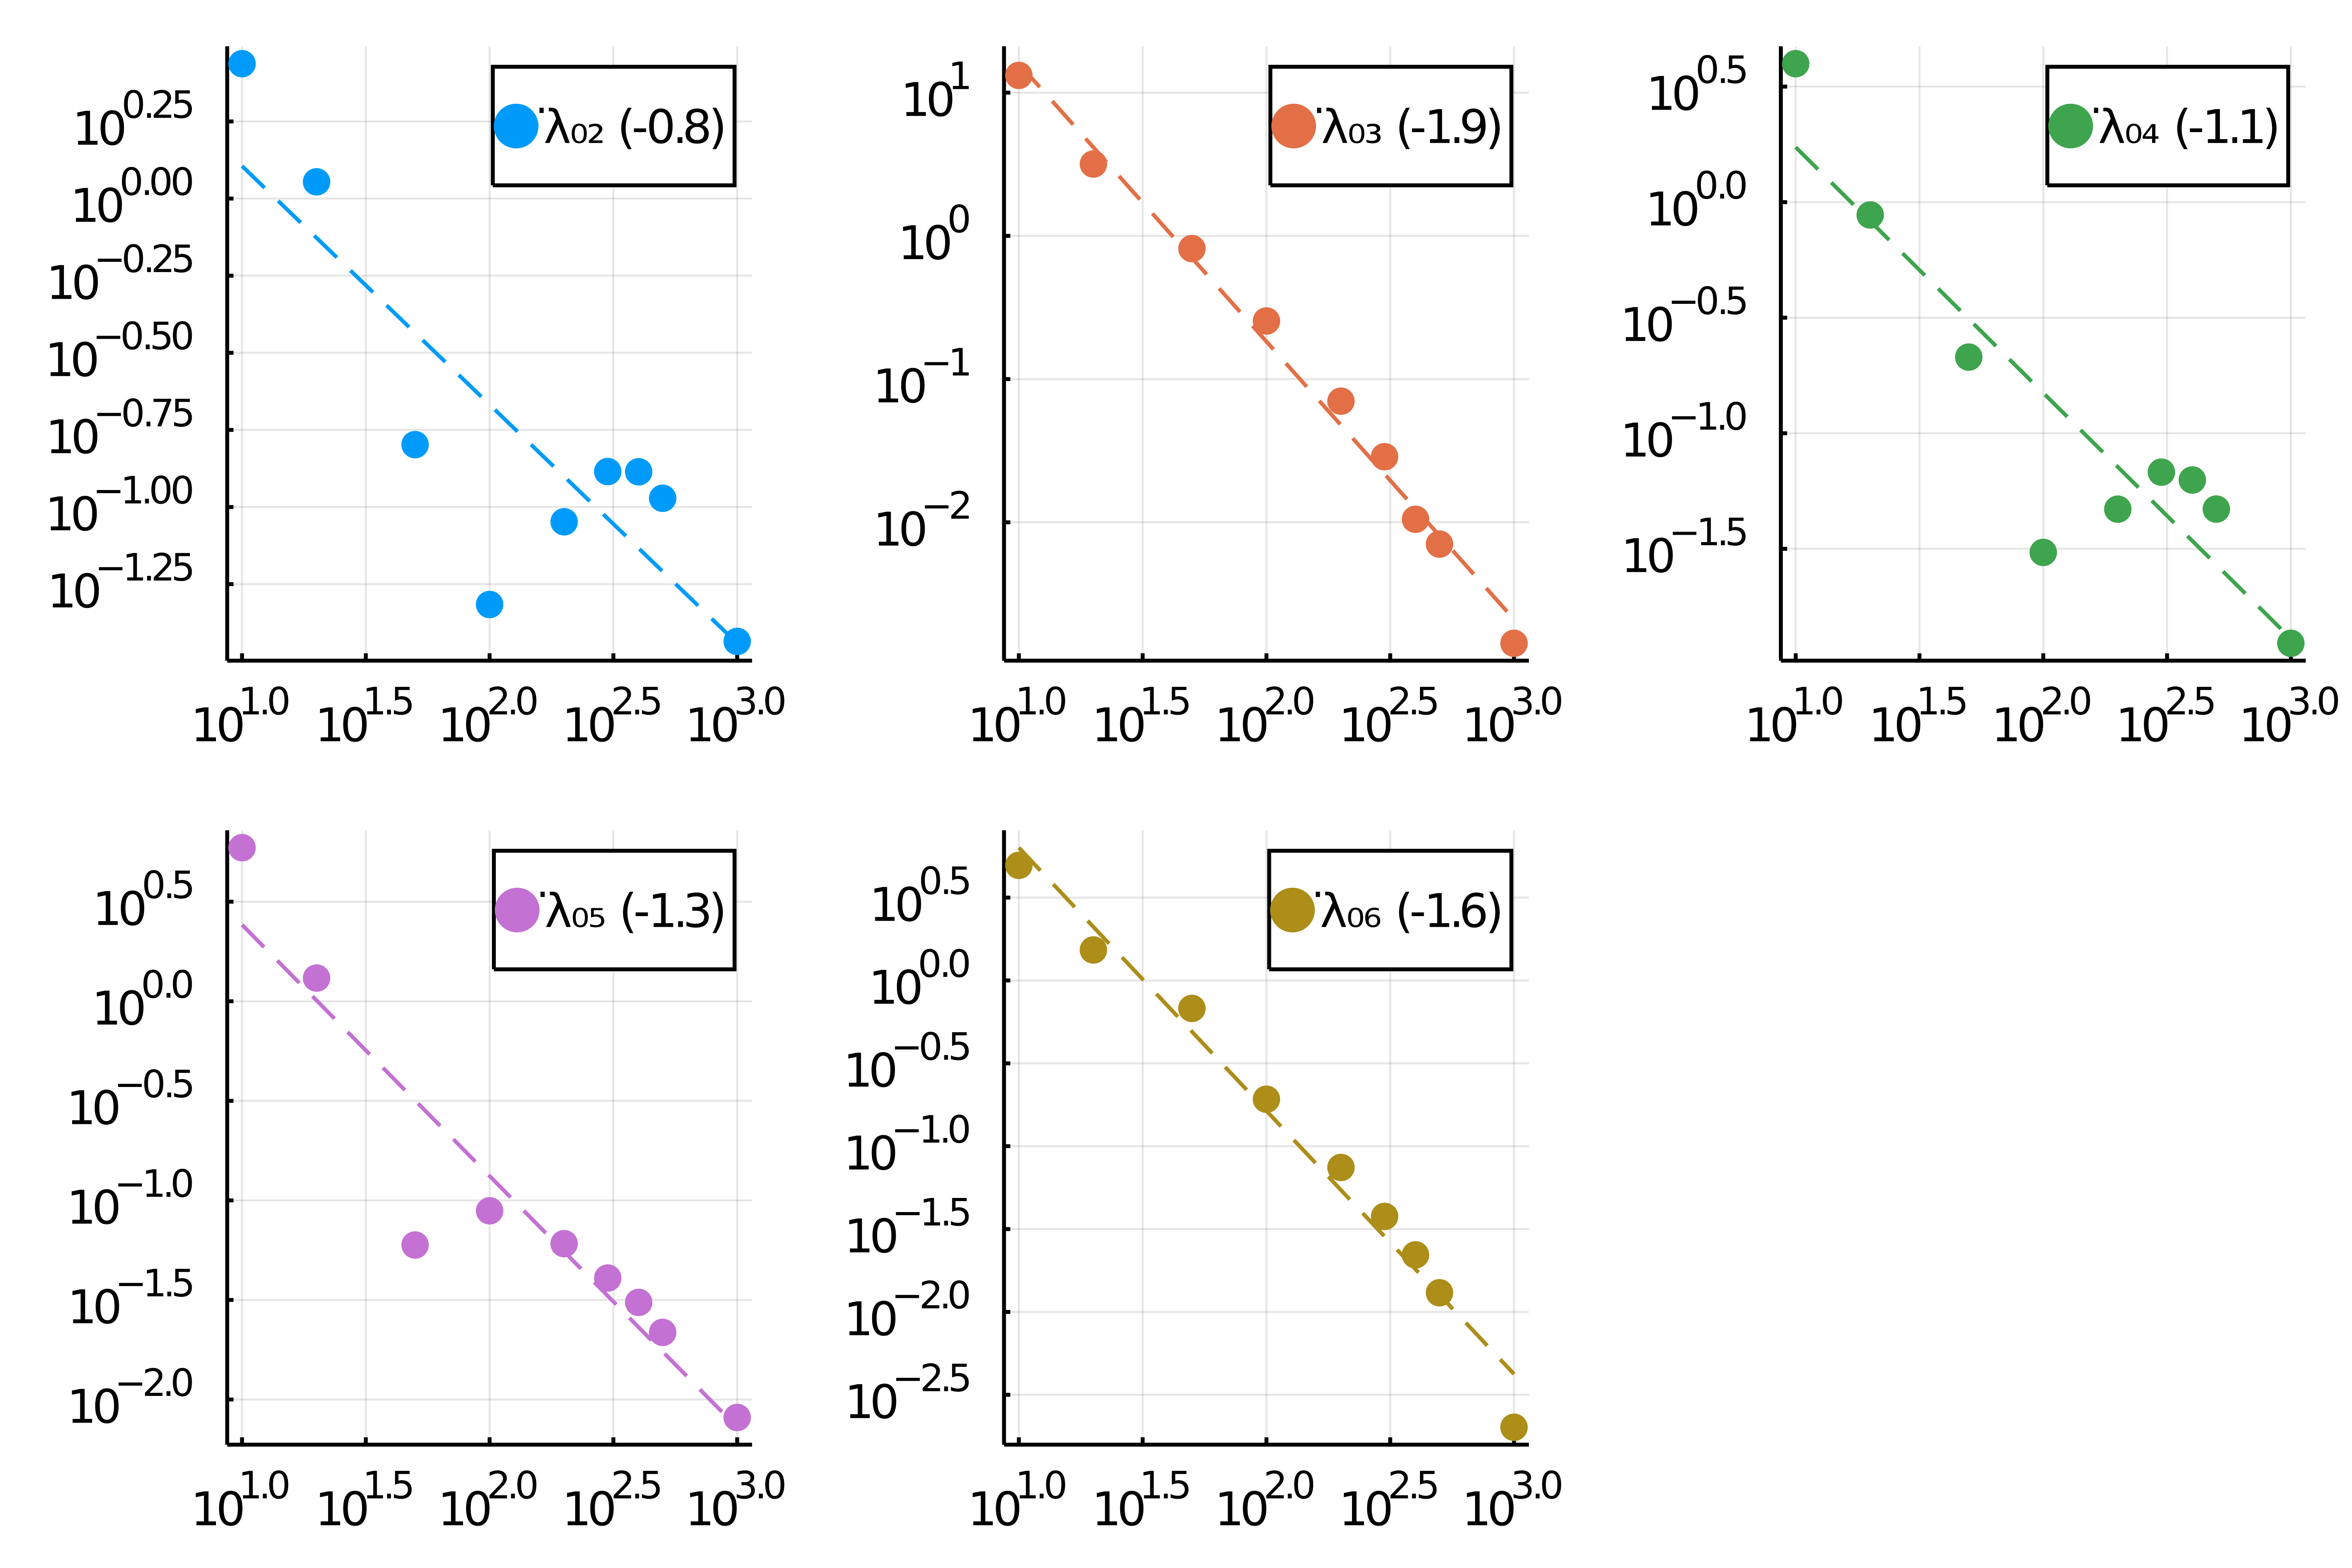

In [20]:
plots = []
labels = ["̇λ₀₂","̇λ₀₃","̇λ₀₄","̇λ₀₅","̇λ₀₆"]
for ev in 1:(num_evs-1)
    plot = makeConvergencePlot([evs_dot_rel_errors[ev]],grid_resolutions,[labels[ev]],colors = [ev])
    push!(plots,plot)
    Plots.savefig(plot,plotfile_path*"error_eigenvalue"*string(ev)*plotfile_suffix*".png")
end
Plots.plot(plots...,share=:y,
          fmt=:png,dpi=1000)

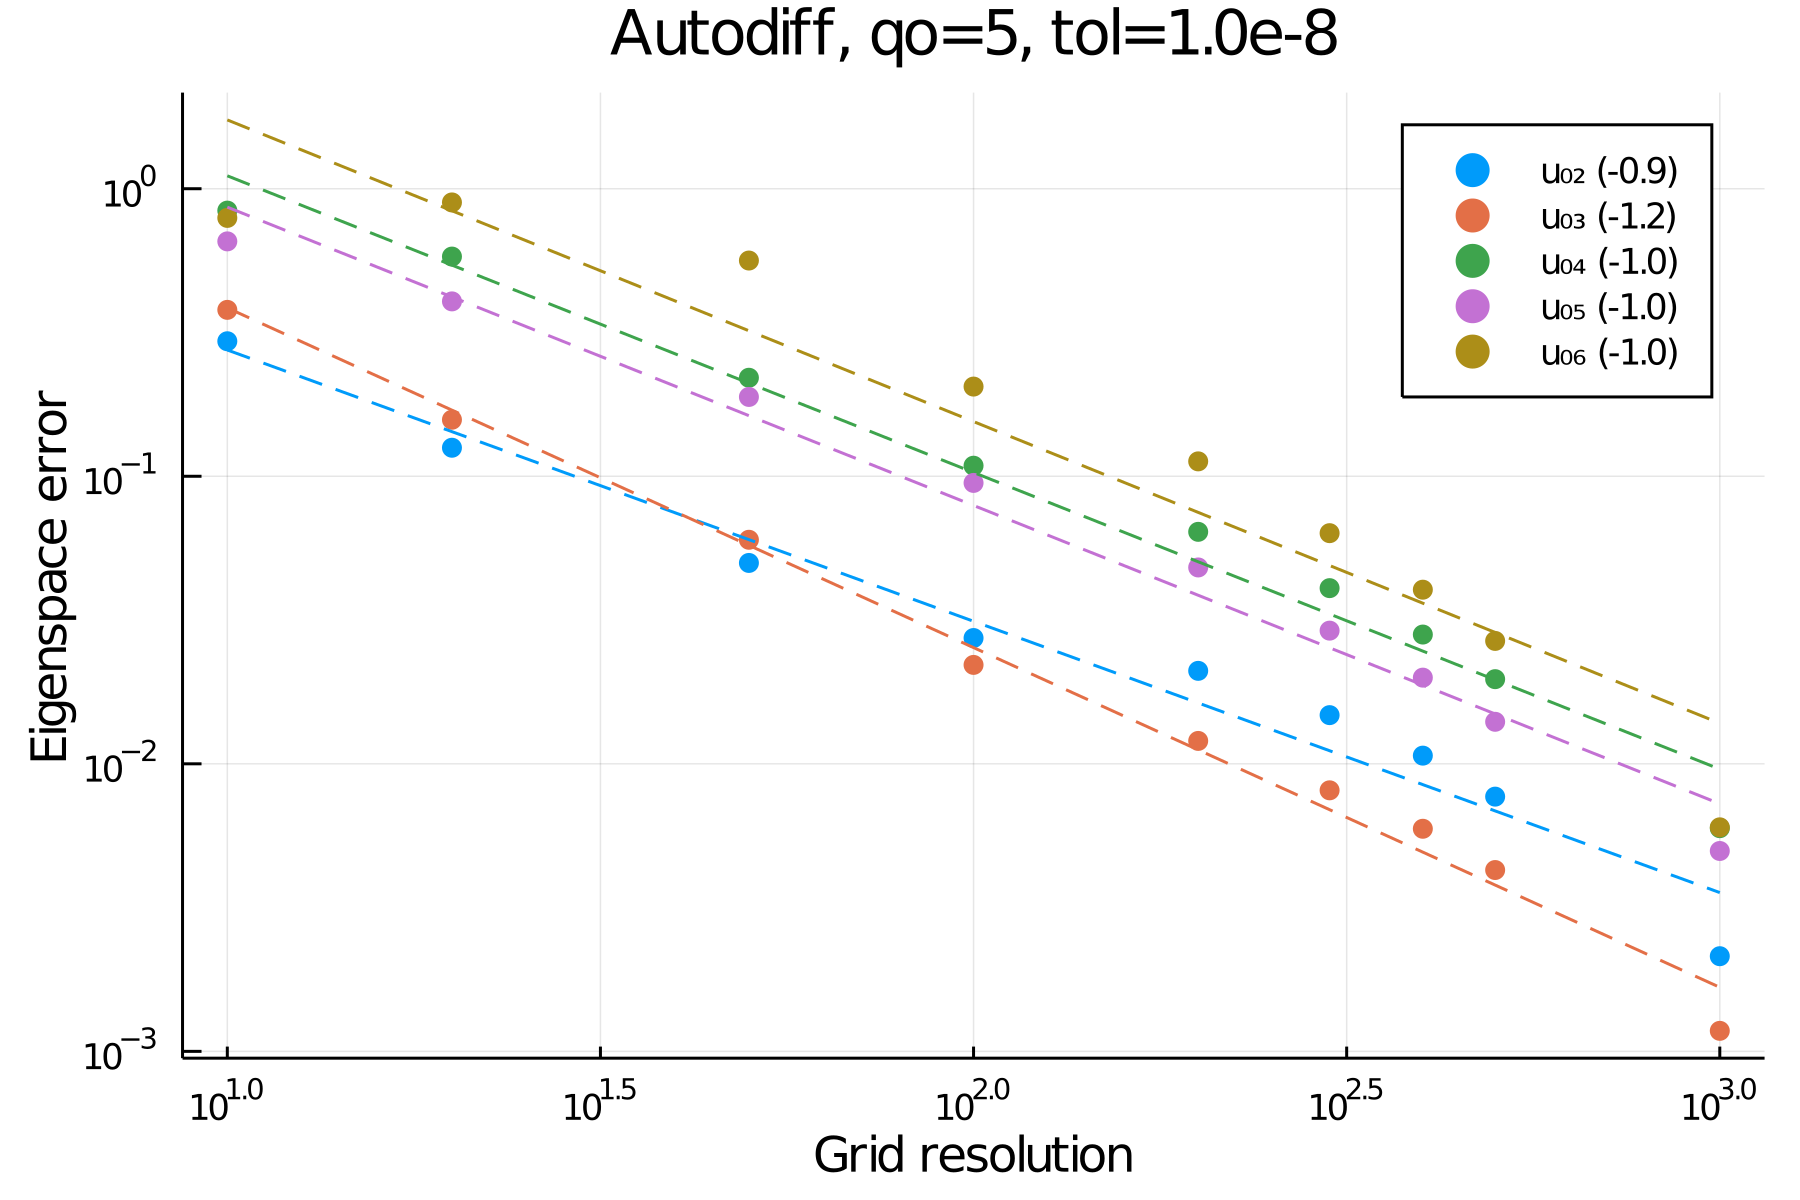

In [21]:
efs_rel_errors = [[getEigenvectorError(ctx_ref,u₀[:,ev],u₀_ref[:,ev],M_ref) for u₀ in u₀s] for ev in 2:num_evs]
plot = Plots.plot(makeConvergencePlot(efs_rel_errors,grid_resolutions,["u₀₂","u₀₃","u₀₄","u₀₅","u₀₆"]),
    xlabel="Grid resolution",ylabel="Eigenspace error",
    title="Autodiff, qo=$(quadrature_order), tol=$(solver_tolerance)",
    fmt=:png,dpi=300)

Plots.savefig(plot,plotfile_path*"error_eigenfunctions"*plotfile_suffix*".png")
Plots.plot(plot)

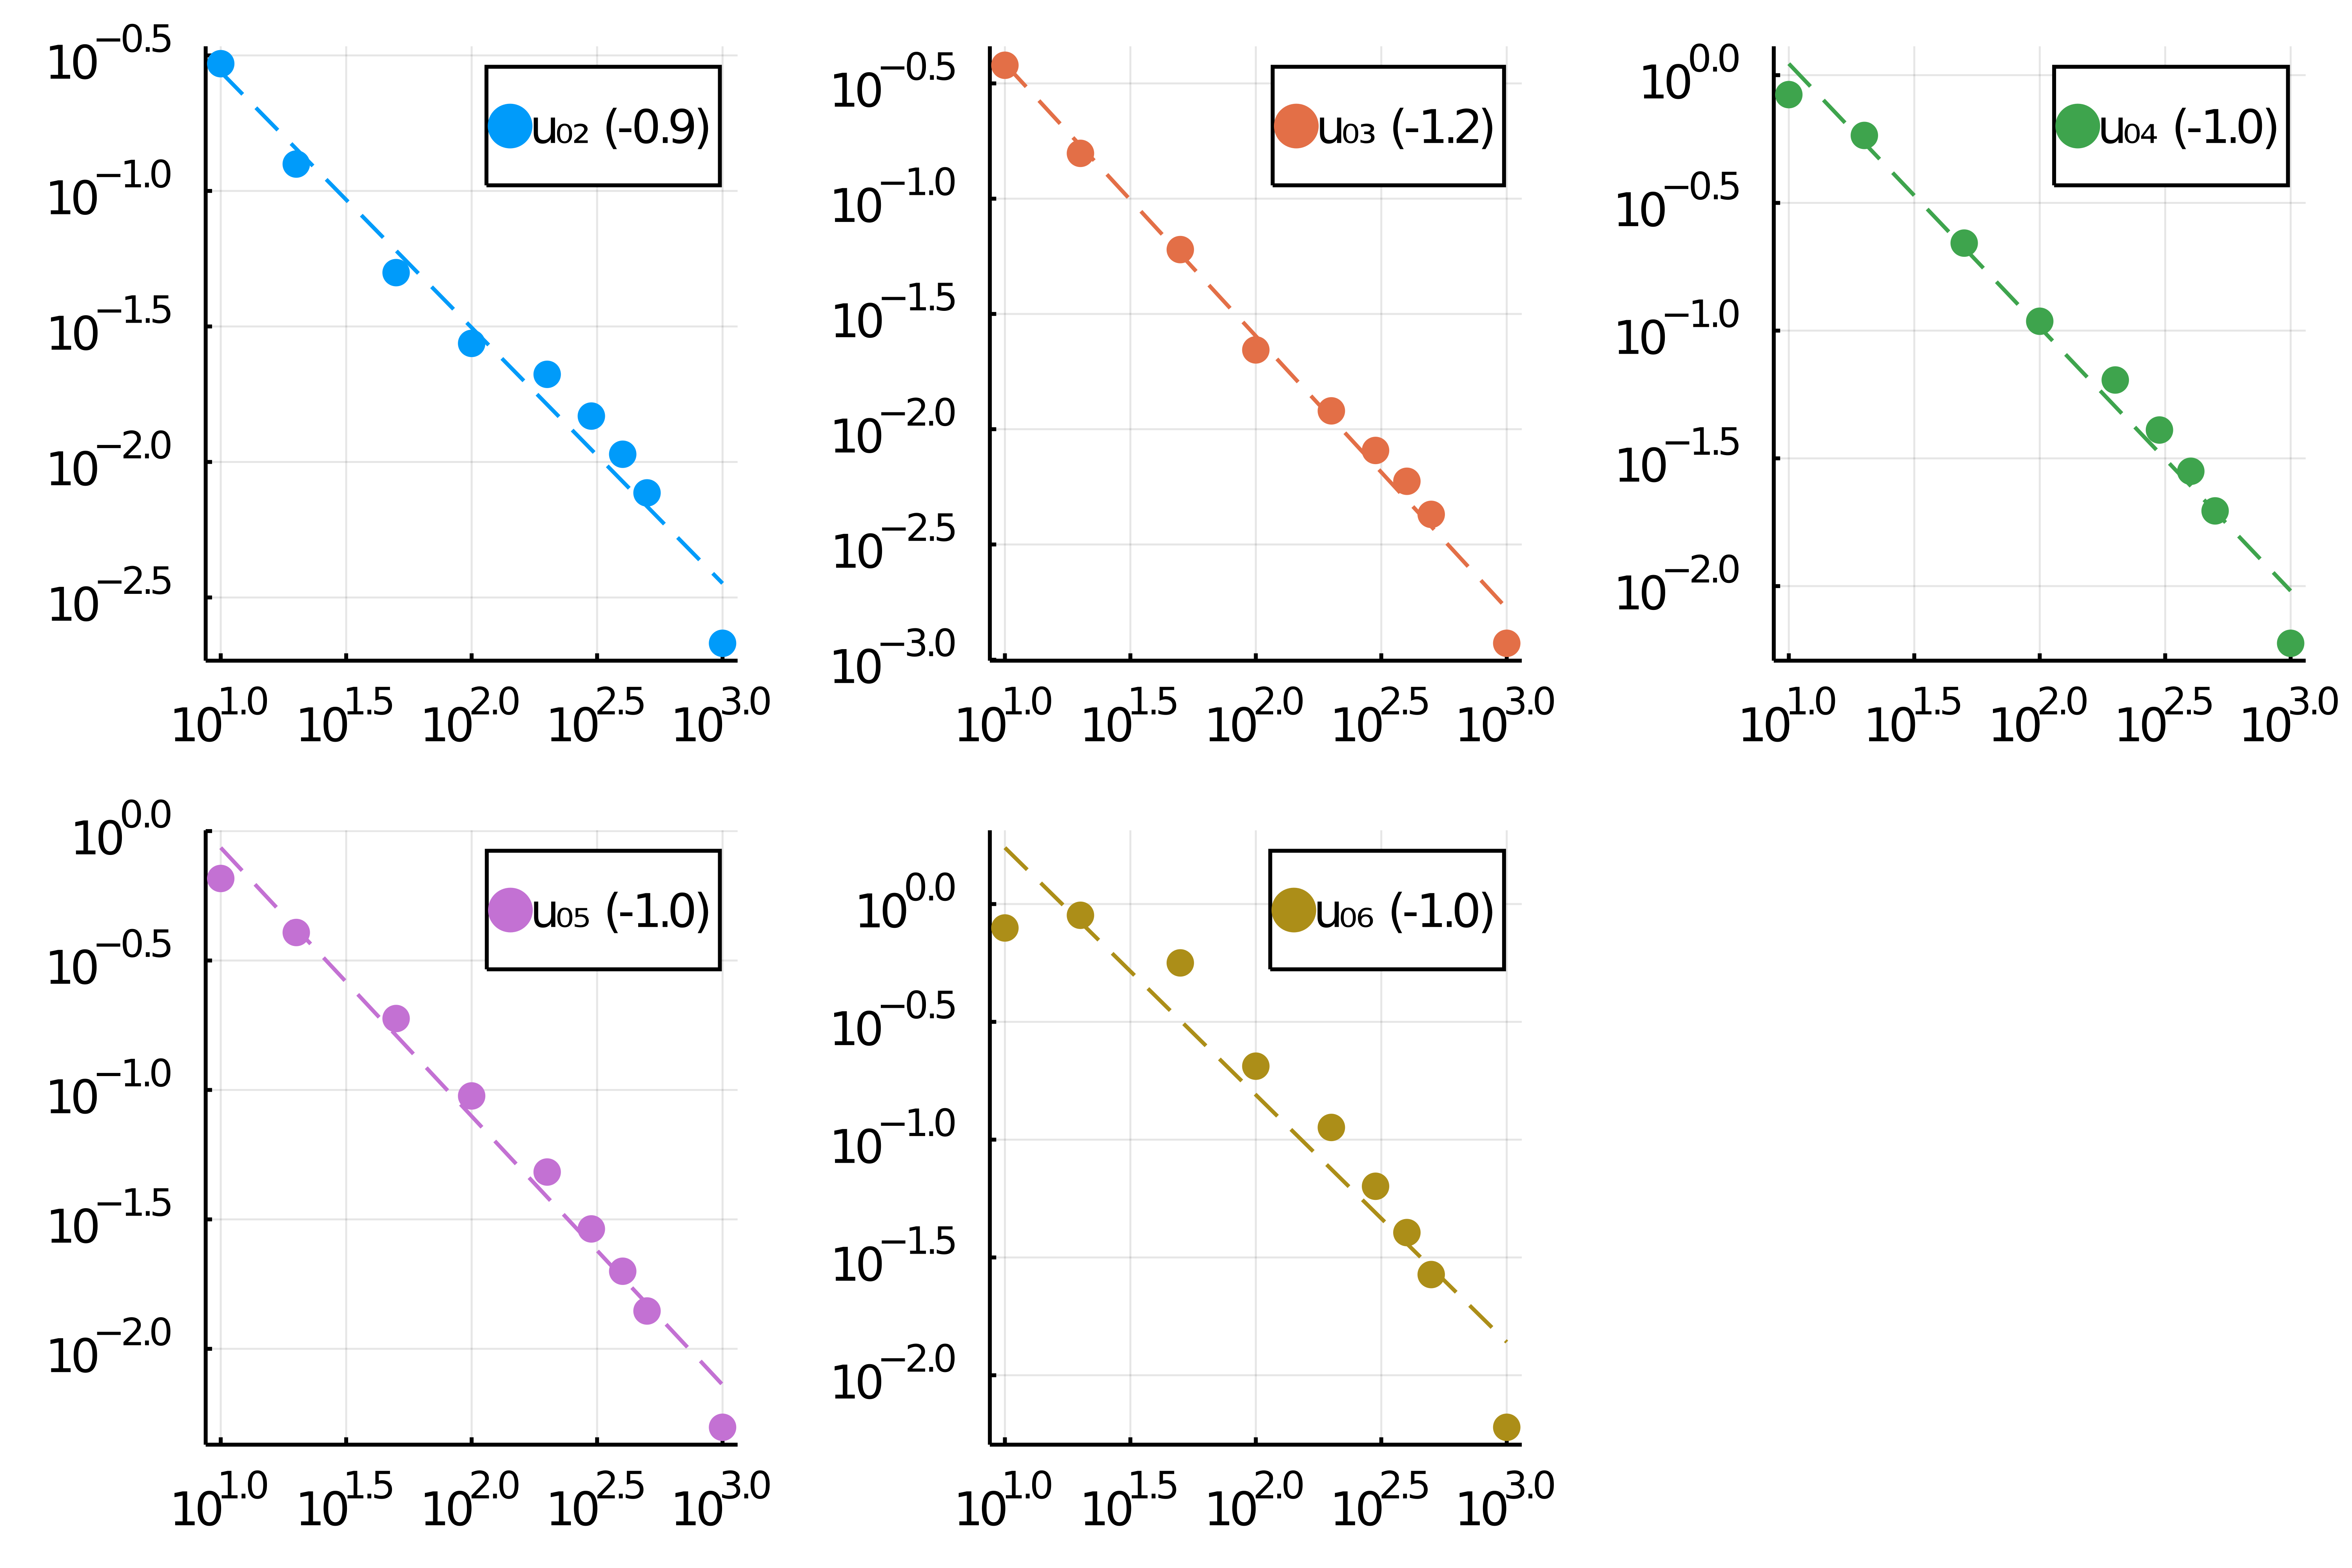

In [22]:
plots = []
labels = ["u₀₂","u₀₃","u₀₄","u₀₅","u₀₆"]
for ev in 1:(num_evs-1)
    plot = makeConvergencePlot([efs_rel_errors[ev]],grid_resolutions,[labels[ev]],colors = [ev])
    push!(plots,plot)
    Plots.savefig(plot,plotfile_path*"error_eigenfunction"*string(ev)*plotfile_suffix*".png")
end
Plots.plot(plots...,share=:y,
          fmt=:png,dpi=1000)

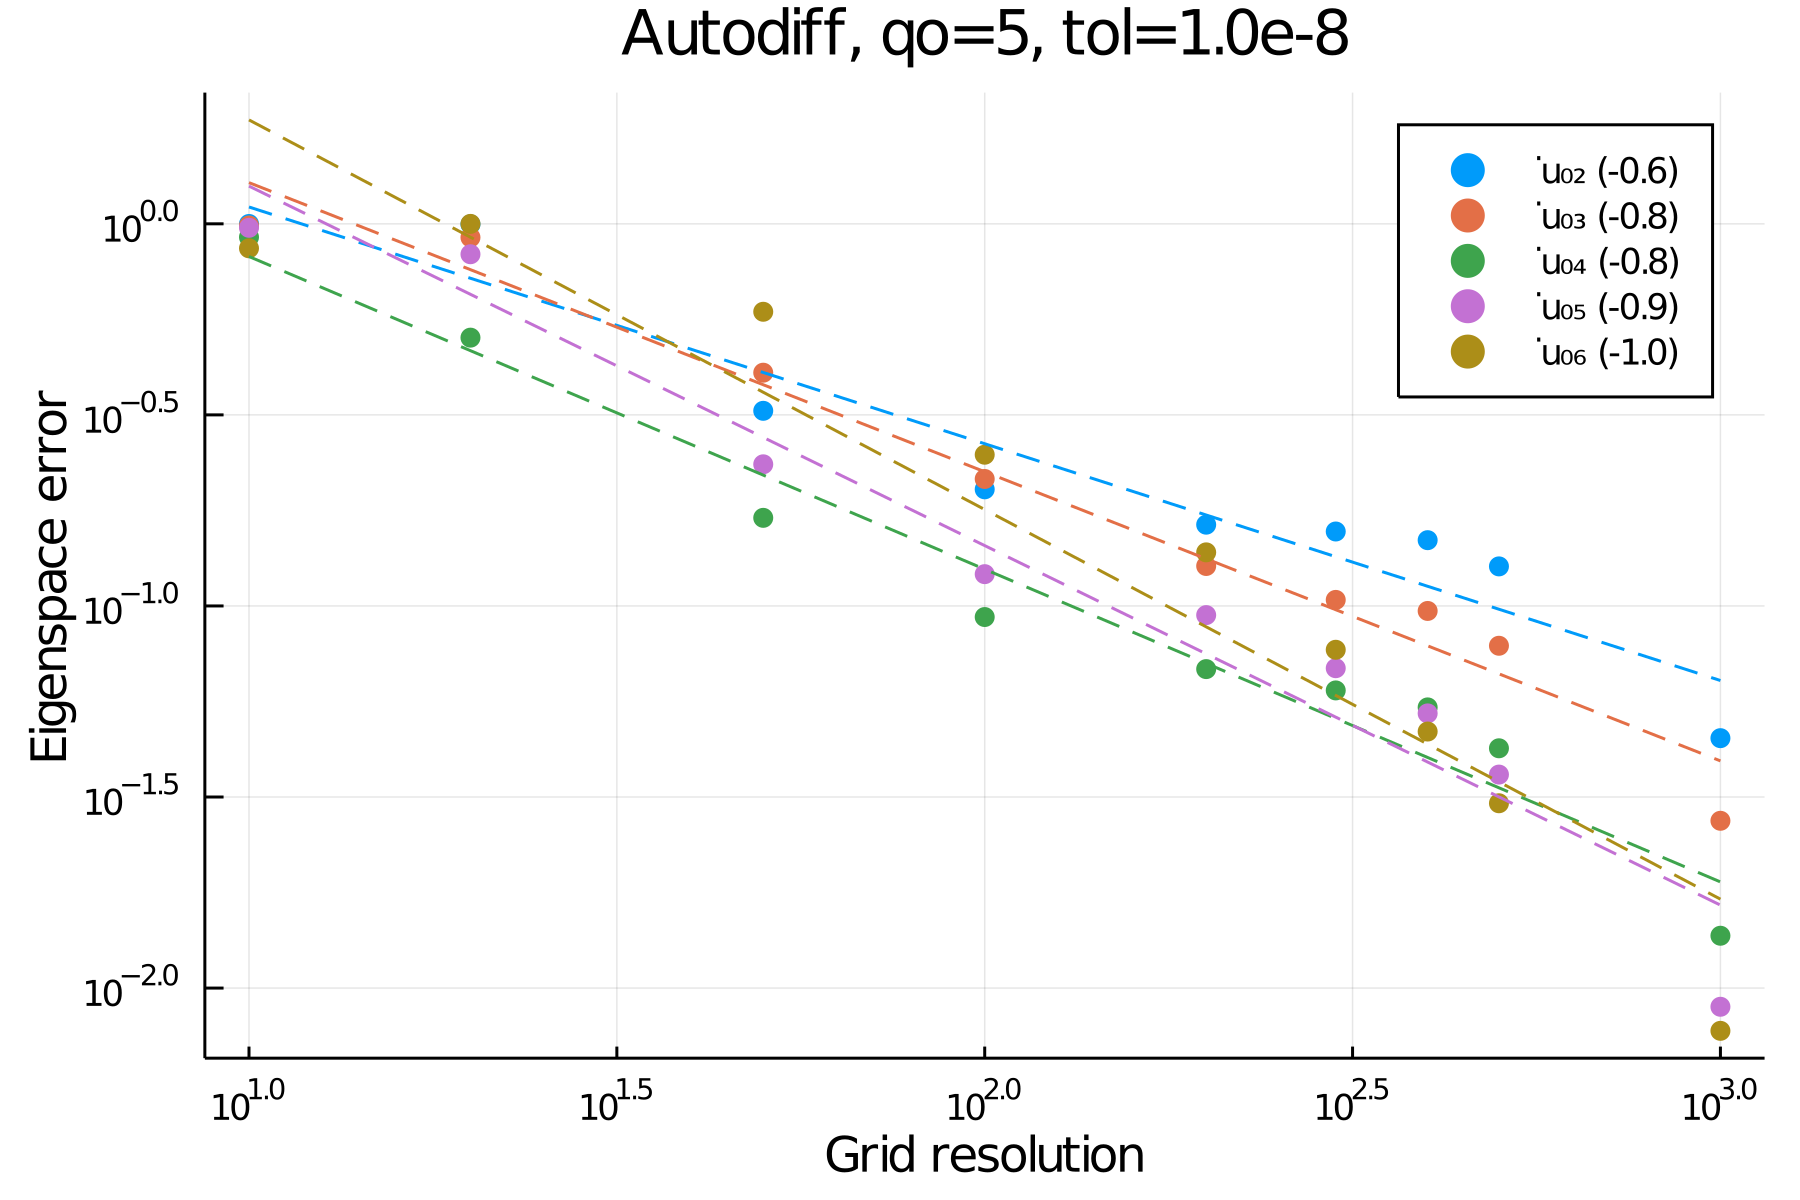

In [23]:
efs_dot_rel_errors = [[getEigenvectorError(ctx_ref,u_dot[:,ev],u_dot_ref[:,ev],M_ref) for u_dot in u_dots] for ev in 2:num_evs]
plot = Plots.plot(makeConvergencePlot(efs_dot_rel_errors,grid_resolutions,["̇u₀₂","̇u₀₃","̇u₀₄","̇u₀₅","̇u₀₆"]),
    xlabel="Grid resolution",ylabel="Eigenspace error",
    title="Autodiff, qo=$(quadrature_order), tol=$(solver_tolerance)",
    fmt=:png,dpi=300)

Plots.savefig(plot,plotfile_path*"error_eigenfunctions"*plotfile_suffix*".png")
Plots.plot(plot)

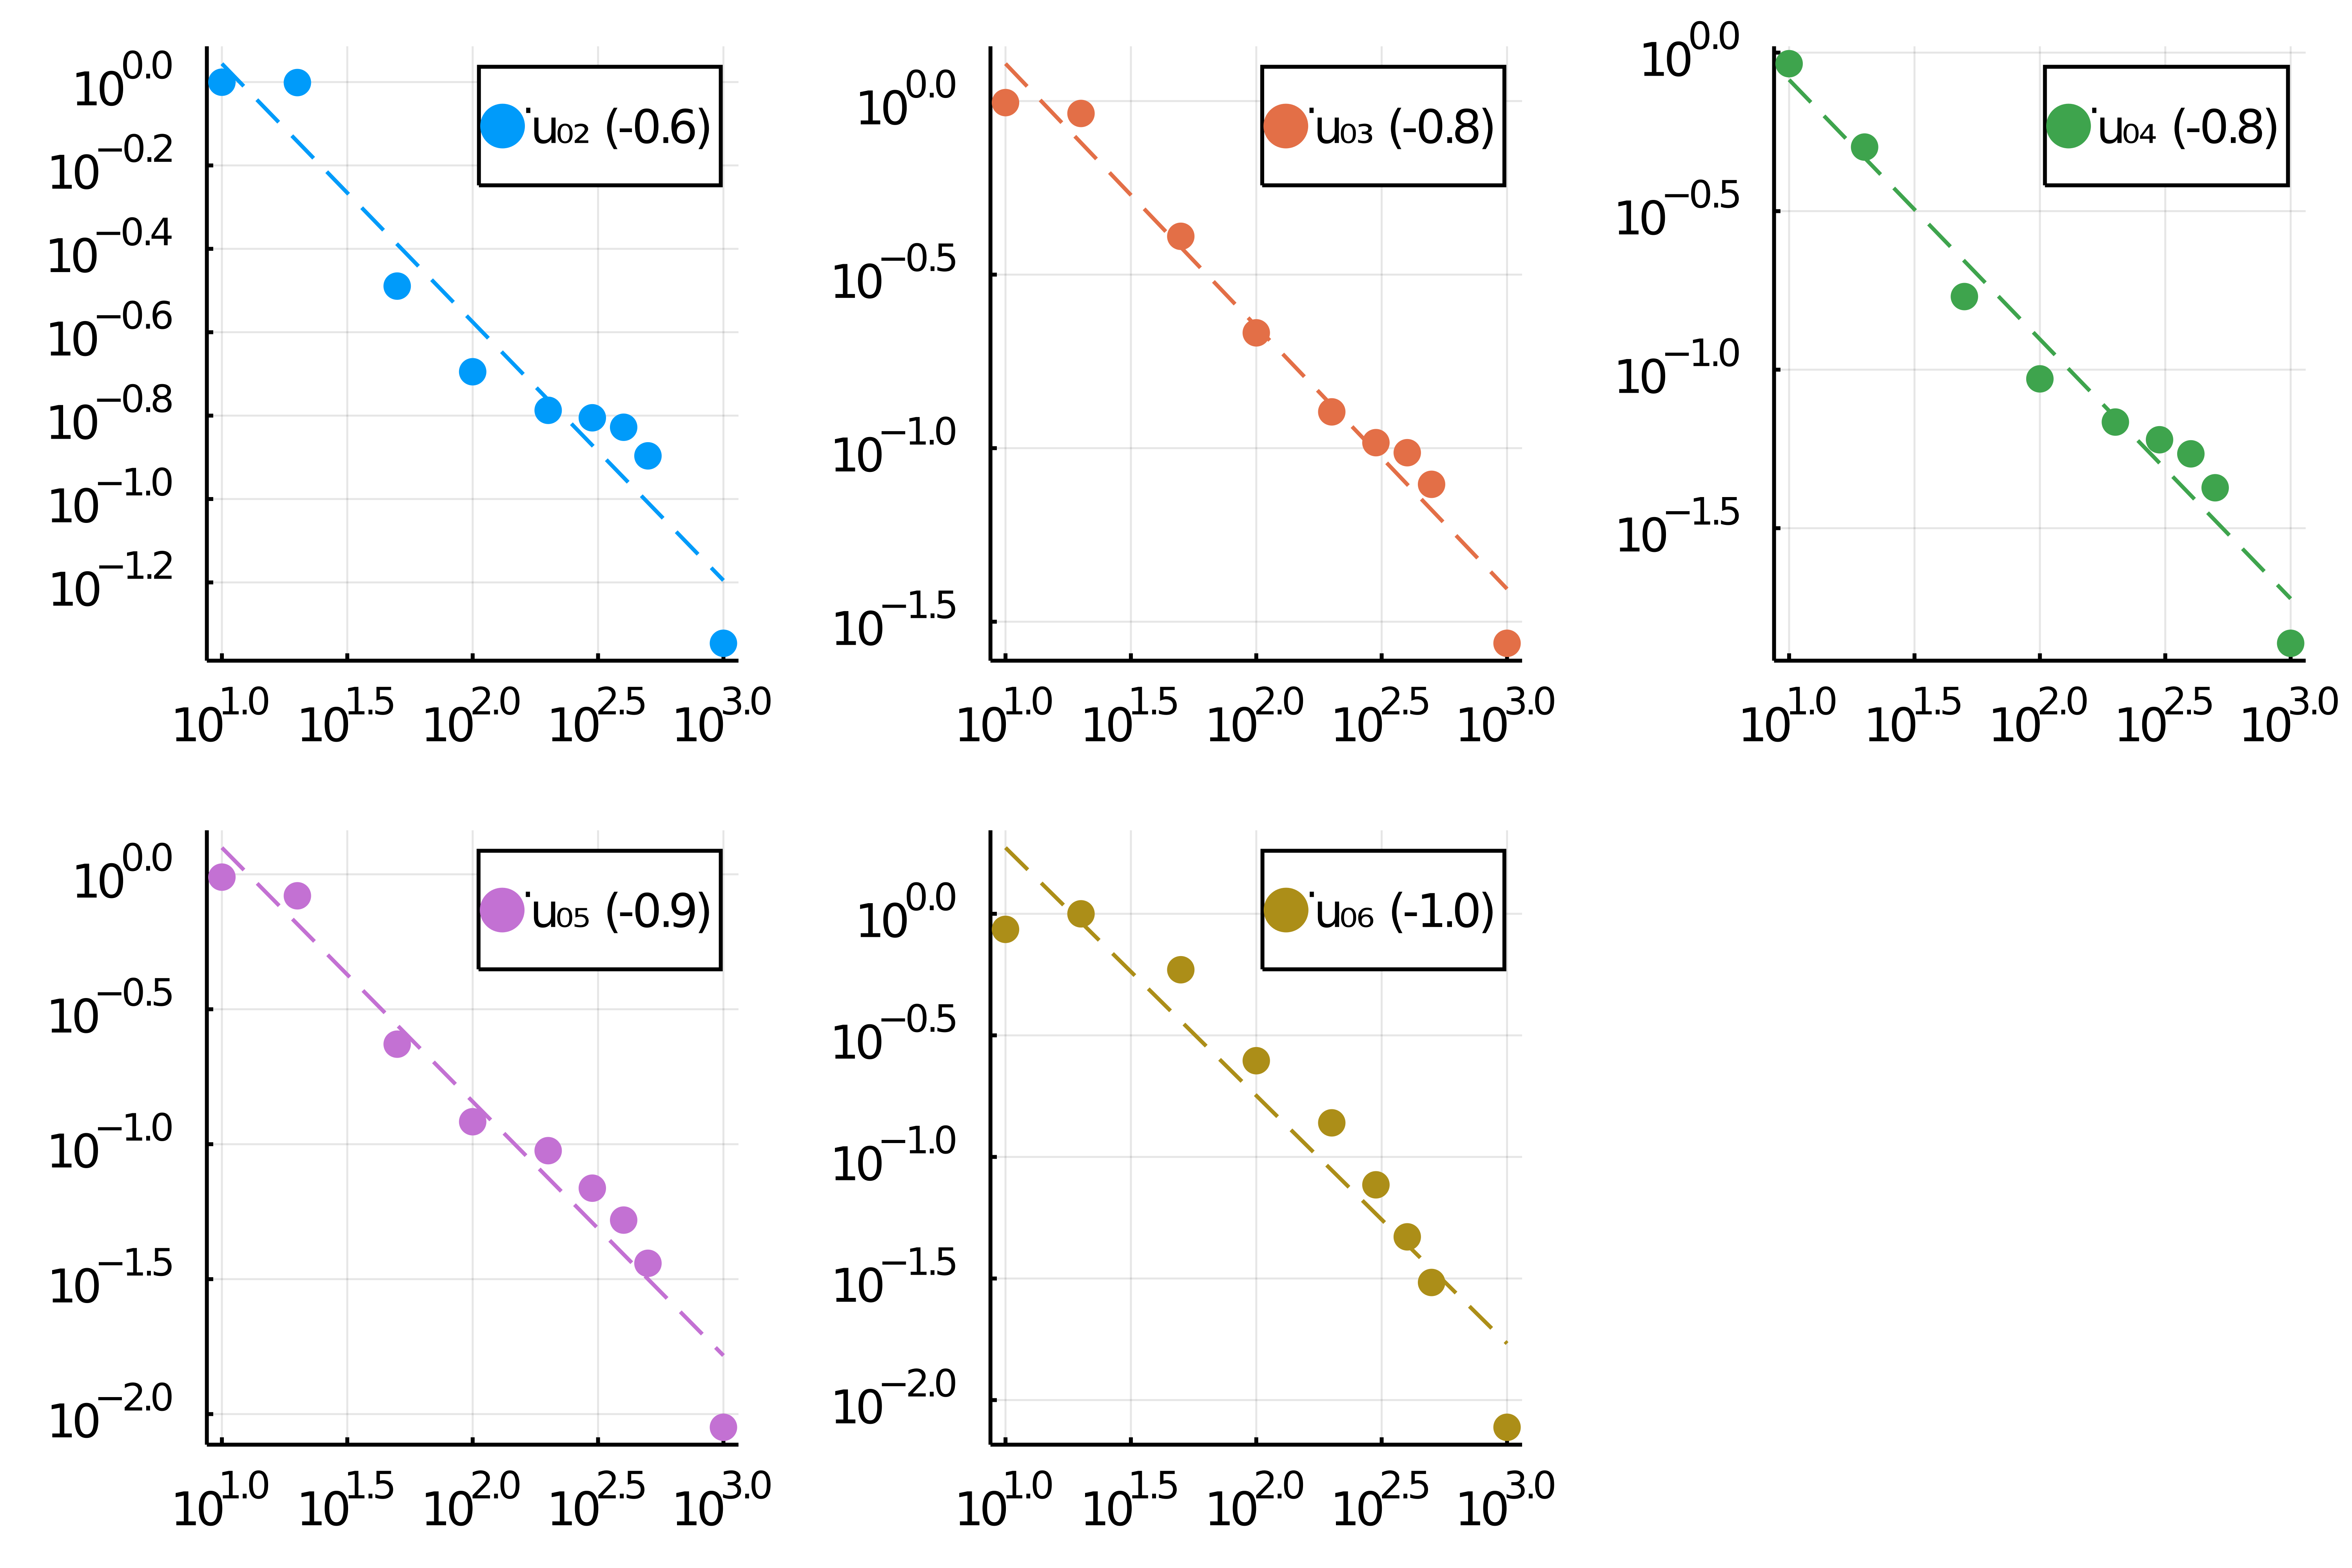

In [24]:
plots = []
labels = ["̇u₀₂","̇u₀₃","̇u₀₄","̇u₀₅","̇u₀₆"]
for ev in 1:(num_evs-1)
    plot = makeConvergencePlot([efs_dot_rel_errors[ev]],grid_resolutions,[labels[ev]],colors = [ev])
    push!(plots,plot)
    Plots.savefig(plot,plotfile_path*"error_eigenfunction"*string(ev)*plotfile_suffix*".png")
end
Plots.plot(plots...,share=:y,
          fmt=:png,dpi=1000)